# A simple example on how to use jQAssistant with Python Pandas
I'm a huge fan of the software analysis framework jQAssistant (http://www.jqassistant.org). It's a great tool for scanning and validating various software artifacts (get a glimpse at https://buschmais.github.io/spring-petclinic/). But I also love Python Pandas (http://http://pandas.pydata.org) as a powerful tool in combination with Jupyter notebook (http://http://jupyter.org/) for reproducible Software Analytics (https://en.wikipedia.org/wiki/Software_analytics).

Combining these tools is near at hand. So I've created a quick demonstration for "first contact" :-)

## Step 0: Preliminary work
For this quick example, I use the jQAssistant example project (https://www.github.com/buschmais/spring-petclinic/) based on the famous Spring PetClinic project. The authors of jQAssistant added a few validation rules and jQAssistant just works plain simple due to the clever Maven integration. If you want to do the same analysis, just clone the project and execute a <tt>mvn clean install</tt>. jQAssistant will then scan the software artifacts and store various data about their structure into the embedded graph database Neo4j (https://neo4j.com). After this command, start the neo4j database instance with <tt>mvn jqassistant:server</tt>. Optional: Check out http://localhost:7474 for directly accessing the Neo4j database.

## Step 1: The imports
Nothing spectacular here. We use the py2neo-Neo4j-connector (http://www.http://py2neo.org) for accessing the underlying Neo4j database instance that jQAssistant brings along. Just install the connector with a <tt>pip install py2neo</tt>. We also import Pandas with a nice short name.

In [1]:
import py2neo
import pandas as pd

## Step 2: Connecting to jQAssistant's embedded neo4j database
The embedded Neo4j installation comes with the standard configuration for port, username, password and an open HTTP port for accessing the database via web services. So there is no need to configure py2neo's connection at all. We just create a Graph object for later usage.

In [2]:
graph = py2neo.Graph()

## Step 3: Executing Cypher queries
For this demonstration, we simply list all the methods that are stored in our database (and marked by the label "Method"). As an example analysis, we would like to know if our application consists just of getters and setters or some real business methods, too. Our query is written in Neo4j's graph query language Cypher (https://neo4j.com/developer/cypher-query-language/) and returns some values (only the first three are displayed).

In [3]:
query = "MATCH (a:Method) RETURN a"
result = graph.data(query)
result[0:3]

[{'a': (d79c8d0:Constructor:Java:Member:Method {cyclomaticComplexity:1,name:"<init>",signature:"void <init>()",visibility:"public"})},
 {'a': (aa25117:Constructor:Java:Member:Method {signature:"void <init>()"})},
 {'a': (df9b612:Java:Member:Method {cyclomaticComplexity:1,name:"getId",signature:"java.lang.Integer getId()",visibility:"public"})}]

## Step 4: Creating a Pandas DataFrame
For the following analysis, we iterate through the dictionary that we'd received from the Neo4j database. We don't need the <tt>"a"</tt> keys that were returned, but only the corresponding values. This is accomplished via Python's list comprehension. We also avoid getting some Nan values in the 'name' column, so we simply drop all empty entries there. We end up with a nice, fully filled DataFrame (only the five rows are displayed).

In [4]:
df = pd.DataFrame.from_dict([data['a'] for data in result]).dropna(subset=['name'])
df.head()

,abstract,cyclomaticComplexity,name,signature,static,synthetic,visibility
0,NaN,1.0,<init>,void <init>(),NaN,NaN,public
2,NaN,1.0,getId,java.lang.Integer getId(),NaN,NaN,public
3,NaN,1.0,setId,void setId(java.lang.Integer),NaN,NaN,public
4,NaN,3.0,isNew,boolean isNew(),NaN,NaN,public
9,NaN,1.0,addPet,void addPet(org.springframework.samples.petcli...,NaN,NaN,public


## Step 5: The analysis
Next we simply work on the <tt>"name"</tt> column to retrieve some information we need for our analysis. In the code, we document our assumptions / heuristics for retrieving the getters and setters (just a subset is displayed for layout reasons).

In [5]:
# filter out all the constructor "methods"
df = df[df['name'] != "<init>"]
# assumption 1: getter start with "get"
df.loc[df['name'].str.startswith("get"), "method_type"] = "Getter"
# assumption 2: "is" is just the same as a getter, just for boolean values
df.loc[df['name'].str.startswith("is"), "method_type"] = "Getter"
# assumption 3: setter start with "set"
df.loc[df['name'].str.startswith("set"), "method_type"] = "Setter"
# assumption 4: all other methods are "Business Methods"
df['method_type'] = df['method_type'].fillna('Business Methods')
df[['name', 'signature', 'visibility', 'method_type']][20:30]

,name,signature,visibility,method_type
47,setDescription,void setDescription(java.lang.String),public,Setter
48,getPet,org.springframework.samples.petclinic.model.Pe...,public,Getter
51,onStartup,void onStartup(javax.servlet.ServletContext),public,Business Methods
53,registerDandelionServlet,void registerDandelionServlet(javax.servlet.Se...,private,Business Methods
54,createRootApplicationContext,org.springframework.web.context.WebApplication...,protected,Business Methods
59,createServletApplicationContext,org.springframework.web.context.WebApplication...,protected,Business Methods
61,getServletMappings,java.lang.String[] getServletMappings(),protected,Getter
62,getServletFilters,javax.servlet.Filter[] getServletFilters(),protected,Getter
66,registerServletFilter,javax.servlet.FilterRegistration$Dynamic regis...,protected,Business Methods
75,loadOwnersPetsAndVisits,void loadOwnersPetsAndVisits(java.util.List),private,Business Methods


## Step 6: Preparing the output
Now we group the data by their method type. We simply count the occurence of each entry and take only the 'name' column for further analysis.

In [6]:
grouped_data = df.groupby('method_type').count()['name']
grouped_data

method_type
Business Methods    146
Getter               33
Setter               27
Name: name, dtype: int64

## Step 7: Visualization
Until now, we could have done most of the work directly in the Neo4j database. But what we want is to create a nice little diagram to display our results. We use matplotlib (http://matplotlib.org) that is integrated with Pandas' DataFrame in a very good way.

In [7]:
import matplotlib.pyplot as plt
# some configuration for displaying nice diagrams directly in the notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
# apply additional style for getting a blank background
plt.style.use('seaborn-white')

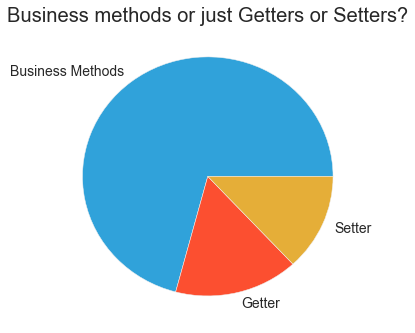

In [8]:
# plot a nice business people compatible pie chart
ax = grouped_data.plot(kind='pie', figsize=(5,5), title="Business methods or just Getters or Setters?")
# get rid of the distracting label for the y-axis
ax.set_ylabel("")

## Summary
This notebook showed a quick demonstration on how to use jQAssistant with Python Pandas within a Jupyter notebook. Granted, we could have done most of your analysis directly with Cypher, but that isn't my main point. The main advantage that comes from the approach here is, that we can do reproducible analysis of software structures based on the notebook approach. Additionally, with Pandas, it's possible to integrate different kind of data sources (relational databases, logfiles, XML files etc.).

More to come in the future, stay tuned!